In [2]:
import pandas as pd
import matplotlib.pyplot as plt
#Import CSV
#colnames, as they are not specified in DS
pd.options.display.max_columns = 50
colnames = ["id", "age", "gender", "education", "country", "ethnicity", 
            "neuroticism", "extraversion", "openness", "agreeableness",
           "conscientiousness", "impulsiveness", "sensation_seeking",
           "alcohol", "amphet", "amyl", "benzos", "caff", "cannabis",
           "choc", "coke", "crack", "ecstasy", "heroin", "ketamine",
           "legalh", "lsd", "meth", "mushrooms", "nicotine", "semer", "vsa"]
drugs = pd.read_csv('data/drug_consumption.csv', header = None, names = colnames, index_col = False)

# preprocessing (reverse transformation)
#relabelling from web source
age = {-0.07854: "25-34", -0.95197: "18-24", 2.59171: "65+", 1.82213: "55-64", 1.09449: "45-54", 0.49788: "35-45"}
gender = {0.48246: "Female", -0.48246: "Male"}
education = {-1.43719: "Left school at 17 years", -1.73790: "Left school at 16 years", -2.43591: "Left school before 16 years",
           0.45468: "University degree", -0.05921: "Professional certificate/ diploma", -0.61113: "Some college or university, no certificate or degree",
           -1.22751: "Left school at 18 years", 1.98437: "Doctorate degree", 1.16365: "Masters degree"}
country = {0.21128: "Republic of Ireland", -0.28519: "Other", -0.46841: "New Zealand", 0.24923: "Canada",
          -0.09765: "Australia", -0.57009: "USA", 0.96082: "UK"}
ethnicity = {-0.31685: "White", 0.11440: "Other", -0.22166: "Mixed-White/Black", 0.12600: "Mixed-White/Asian",
           1.90725: "Mixed-Black/Asian", -1.10702: "Black", -0.50212: "Asian"}

# rounding error must be corrected: website only contains 5 decimal numbers
drugs.age = round(drugs.age,5)
drugs.age = drugs.age.replace(age.keys(), age.values())
drugs.gender = round(drugs.gender, 5)
drugs.gender = drugs.gender.replace(gender.keys(), gender.values())
drugs.education = round(drugs.education, 5)
drugs.education = drugs.education.replace(education.keys(), education.values())
drugs.country = round(drugs.country, 5)
drugs.country = drugs.country.replace(country.keys(), country.values())
drugs.ethnicity = round(drugs.ethnicity, 5)
drugs.ethnicity = drugs.ethnicity.replace(ethnicity.keys(), ethnicity.values())

drugs.head()

#list of dicts for reverse transformation of the other variables
#these variables have more possible values, so it would be very time
#intense to do that manually as well
label_list = []
#extract informatioin from txt file created from web source
with open("data/drug_data-description.txt", "r") as file:
    data = file.readlines()
    for line in data:
        ### if line start with digit -> new variable section begins
        if line[0].isdigit():
            ### create new dict in list for each variable
            label_list.append(dict())
        ### only lines starting with <br> contain information
        if line[0:4] == "<br>":
            ### get clean numbers out of line
            numbers = line.split()[1:]
            #transform them from str to numeric
            for i in range(len(numbers)):
                if numbers[i].isdigit():
                    numbers[i] = int(numbers[i])
                else:
                    numbers[i] = float(numbers[i])
            ### append needed values to last (current) dict in list
            if len(numbers) == 6:
                numbers.pop(1)
                numbers.pop(3)
            if len(numbers) == 9:
                numbers.pop(1)
                numbers.pop(3)
                numbers.pop(5)
            for i in range(1, len(numbers), 2):
                label_list[len(label_list)-1][numbers[i]] = numbers[i-1]

## retransform variables according to dict
for i in range(len(label_list)):
    drugs.iloc[:,i+6] = round(drugs.iloc[:, i+6], 5)
    drugs.iloc[:,i+6] = drugs.iloc[:,i+6].replace(label_list[i].keys(), label_list[i].values())

#change data types
for i in range(1, 6):
    drugs[colnames[i]] = drugs[colnames[i]].astype("category")
for i in range(6, 11):
    drugs[colnames[i]] = drugs[colnames[i]].astype("int32")
    
#########takes some time
#### removing "CL*"    
for i in range(13, len(colnames)):
    for j in range(0, len(drugs[colnames[i]])):
        drugs.iloc[j,i] = int(drugs.iloc[j,i][-1])
drugs.head()

for i in range(13, len(colnames)):
    drugs[colnames[i]] = drugs[colnames[i]].astype("category")
print(drugs.info())
print(drugs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 32 columns):
id                   1885 non-null int64
age                  1885 non-null category
gender               1885 non-null category
education            1885 non-null category
country              1885 non-null category
ethnicity            1885 non-null category
neuroticism          1885 non-null int32
extraversion         1885 non-null int32
openness             1885 non-null int32
agreeableness        1885 non-null int32
conscientiousness    1885 non-null int32
impulsiveness        1885 non-null float64
sensation_seeking    1885 non-null float64
alcohol              1885 non-null category
amphet               1885 non-null category
amyl                 1885 non-null category
benzos               1885 non-null category
caff                 1885 non-null category
cannabis             1885 non-null category
choc                 1885 non-null category
coke                 1885 non-nul

### Data Set Description

The Data Set contains information about the frequency of drug use depending on different demographic and psychological attributes. It contains 1885 observations on 32 variables, wehereas one is the ID and 19 can be considered as target variables as they contain information on the frequencey of drug use on different kind of drugs. We decided to only work on one specific drug (cannabis). Therefore the data set consists of 12 features. The features are numerical and categorical. The target variable has seven different values (never used the drug - used it yesterday), therefore it can be considered as a multiple class problem.
The target variable is inequally distributed as most people eather never consumed cannabis or used it wihtin the last day (both > 20%). Inbetween the values vary about 10%. Most people are and come form UK or USA and are mostly young (< 25 years). Almost all participants have a degree, indicating that the study was conducted at university. The psychological attributes are approximately normally distributed. There are only very few values which are extreme outliers beside that there are no peculiarities. The data set does not contain missing values.


## 3 Statistical Analysis

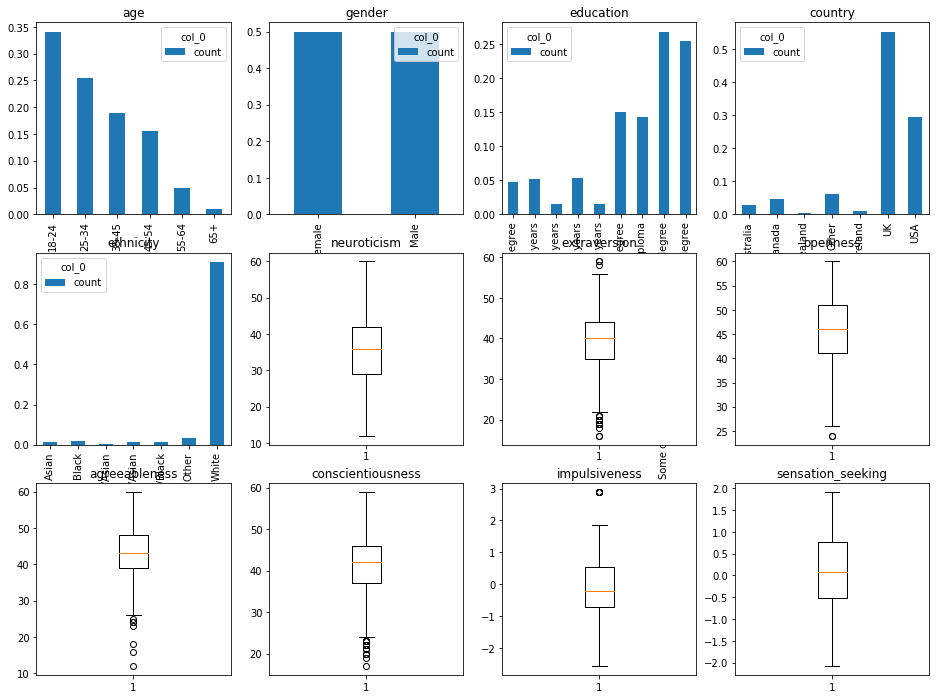

In [2]:
fig, axlist = plt.subplots(3,4,figsize=(16,12))
variable = 1
for row in range(0,3):
    for i in range(0,4):
        if drugs[colnames[variable]].dtype == "int32" or drugs[colnames[variable]].dtype == "float64":
            axlist[row][i].boxplot(drugs[colnames[variable]])
            axlist[row][i].set_title(colnames[variable])
        else:
            tab = pd.crosstab(drugs[colnames[variable]], columns="count")
            rel_tab = tab/tab.sum()
            rel_tab.plot(kind = "bar", ax = axlist[row][i])
            axlist[row][i].set_title(colnames[variable])
        variable += 1

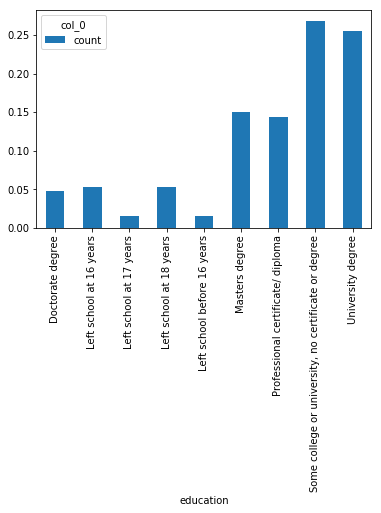

In [3]:
tab = pd.crosstab(drugs["education"], columns = "count")
rel_tab = tab/tab.sum()
rel_tab.plot(kind = "bar")

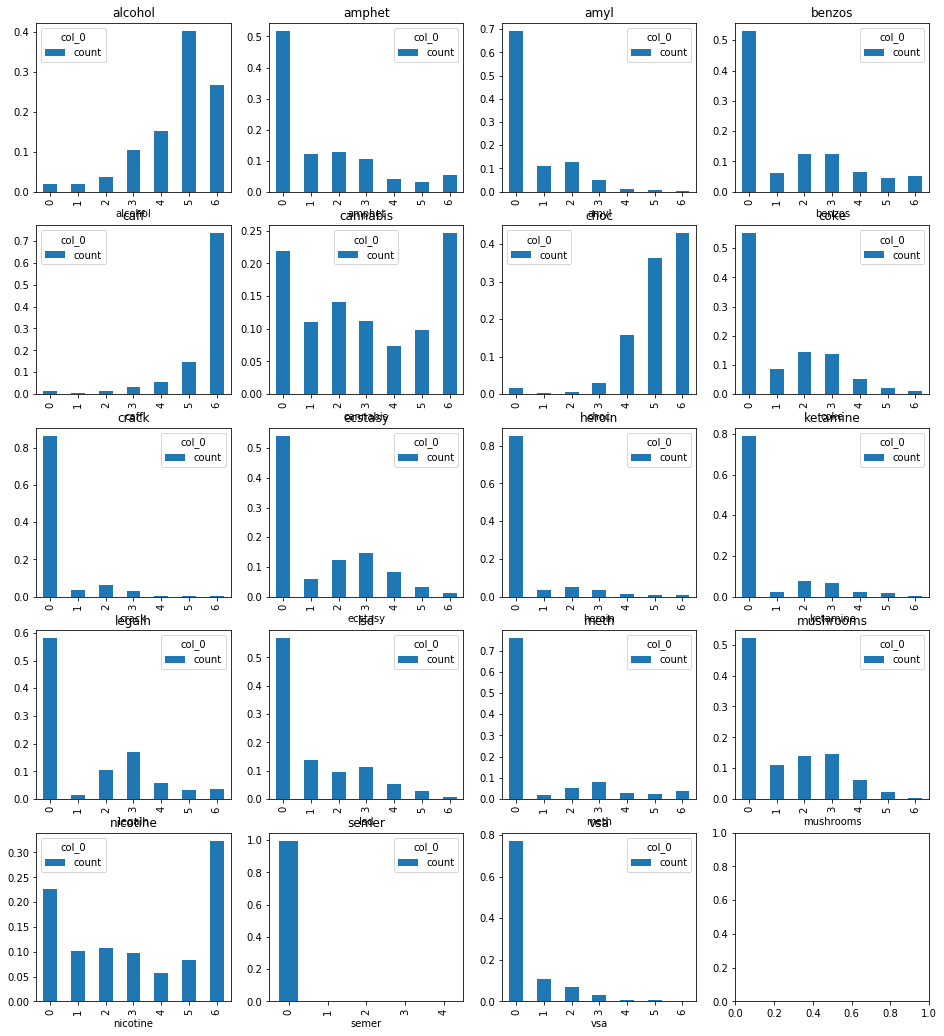

In [4]:
fig, axlist = plt.subplots(5,4,figsize=(16,18))
for row in range(0,5):
    for i in range(0,4):
        tab = pd.crosstab(drugs[colnames[variable]], columns="count")
        rel_tab = tab/tab.sum()
        rel_tab.plot(kind = "bar", ax = axlist[row][i])
        axlist[row][i].set_title(colnames[variable])
        if variable == 31:
            break
        variable += 1

In [5]:
drugs.isna().sum() # The number of missing values per Attribute (column)

id                   0
age                  0
gender               0
education            0
country              0
ethnicity            0
neuroticism          0
extraversion         0
openness             0
agreeableness        0
conscientiousness    0
impulsiveness        0
sensation_seeking    0
alcohol              0
amphet               0
amyl                 0
benzos               0
caff                 0
cannabis             0
choc                 0
coke                 0
crack                0
ecstasy              0
heroin               0
ketamine             0
legalh               0
lsd                  0
meth                 0
mushrooms            0
nicotine             0
semer                0
vsa                  0
dtype: int64

In [6]:
drugs.shape # Check dimensions

(1885, 32)

In [7]:
drugs.iloc[:,1:].describe() #without id

,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation_seeking
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,35.921485,39.576127,45.762334,42.866313,41.437135,0.007216,-0.003292
std,9.135869,6.771769,6.579641,6.438106,6.966625,0.954435,0.963701
min,12.000000,16.000000,24.000000,12.000000,17.000000,-2.555240,-2.078480
25%,29.000000,35.000000,41.000000,39.000000,37.000000,-0.711260,-0.525930
50%,36.000000,40.000000,46.000000,43.000000,42.000000,-0.217120,0.079870
75%,42.000000,44.000000,51.000000,48.000000,46.000000,0.529750,0.765400
max,60.000000,59.000000,60.000000,60.000000,59.000000,2.901610,1.921730


There is no statistical summary for categorical data. We can get a summary of the categorical variables by passing only those columns to describe():

In [8]:
categorical = drugs.dtypes[drugs.dtypes == "category"].index #gives list of attributes that are categorical
drugs[categorical].describe()

,age,gender,education,country,ethnicity,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
count,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885
unique,6,2,9,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,5,7
top,18-24,Male,"Some college or university, no certificate or ...",UK,White,5,0,0,0,6,6,6,0,0,0,0,0,0,0,0,0,6,0,0
freq,643,943,506,1044,1720,759,976,1305,1000,1385,463,807,1038,1627,1021,1605,1490,1094,1069,1429,982,610,1877,1455


In [9]:
#list of proportional frequency tables
prop_tables = []
for variable in categorical:
    tab = pd.crosstab(drugs[variable], columns="count")
    rel_tab = tab/tab.sum()
    prop_tables.append(rel_tab)

print(categorical)

for i in [0, 2, 5, 14]:
    print(prop_tables[i])
    print()
    

Index(['age', 'gender', 'education', 'country', 'ethnicity', 'alcohol',
       'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc', 'coke', 'crack',
       'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'mushrooms',
       'nicotine', 'semer', 'vsa'],
      dtype='object')
col_0     count
age            
18-24  0.341114
25-34  0.255172
35-45  0.188859
45-54  0.155968
55-64  0.049337
65+    0.009549

col_0                                                  count
education                                                   
Doctorate degree                                    0.047215
Left school at 16 years                             0.052520
Left school at 17 years                             0.015915
Left school at 18 years                             0.053050
Left school before 16 years                         0.014854
Masters degree                                      0.150133
Professional certificate/ diploma                   0.143236
Some college or university, no cer

## Testing Algorithms

In [123]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn import metrics


import random

def linear_experiment(classifier, Xdata, Ydata, scoring = ["explained_variance", "r2" ,"mean_squared_error", "mean_absolute_error"], cv=10):
    #explained variance: how many percent of the variance are explained?
    #r^2: How many percent of the absolut squared error are explained
    random.seed(0)
    results = cross_validate(classifier, Xdata, Ydata, scoring = scoring, cv=cv, return_train_score=False)
    rval = {}
    for i in results:
        rval[i] =  results[i].mean()
    for i in ["test_mean_squared_error", "test_mean_absolute_error"]:
        if rval[i] < 0:
            rval[i] = rval[i]*-1
    return rval


In [102]:
#### unpreprocessed data
Xdata = pd.concat([drugs.iloc[:,1:5], drugs.iloc[:,13:drugs.shape[1]]], axis = 1)
for i in range(0,4):
    label_encoder = LabelEncoder()
    Xdata.iloc[:,i] = label_encoder.fit_transform(Xdata.iloc[:,i])
Ydata = drugs.conscientiousness
for i in range(0, 4):
    Xdata.iloc[:,i] = Xdata.iloc[:,i].astype("category")

In [104]:
#### dummy encoding
Xdata_dummy = pd.get_dummies(Xdata)

#### Linear Regression

##### Unprocessed Data

In [111]:
original_results = linear_experiment(LinearRegression(), Xdata, Ydata)
original_results

{'fit_time': 0.011418461799621582,
 'score_time': 0.015816736221313476,
 'test_explained_variance': 0.07175512677804033,
 'test_r2': 0.06741724113234814,
 'test_mean_squared_error': 43.489369217847404,
 'test_mean_absolute_error': 5.227060206930931}

##### Dummy Encoding

In [122]:
dummy_results = linear_experiment(LinearRegression(), Xdata_dummy, Ydata)
dummy_results

{'fit_time': 0.013358259201049804,
 'score_time': 0.0013640880584716796,
 'test_explained_variance': -1.2635410940743834e+20,
 'test_r2': -1.2751016786782359e+20,
 'test_mean_squared_error': 6.20900451318961e+21,
 'test_mean_absolute_error': 3221427925.466352}

##### Gradient Descent 

In [126]:
gd_original_results = linear_experiment(SGDRegressor(max_iter = 100, tol =None), Xdata, Ydata)
gd_original_results

{'fit_time': 0.034601354598999025,
 'score_time': 0.015269231796264649,
 'test_explained_variance': 0.0383898168312586,
 'test_r2': -0.012053404378245546,
 'test_mean_squared_error': 46.55747819945769,
 'test_mean_absolute_error': 5.4573324783668244}

In [127]:
gd_dummy_results = linear_experiment(SGDRegressor(max_iter = 100, tol =None), Xdata_dummy, Ydata)
gd_dummy_results

{'fit_time': 0.0860738754272461,
 'score_time': 0.0013104915618896485,
 'test_explained_variance': 0.04564847909922881,
 'test_r2': 0.04055141280778888,
 'test_mean_squared_error': 44.74676302017133,
 'test_mean_absolute_error': 5.301185964472836}

In [43]:
drugs_original = pd.read_csv('data/drug_consumption.csv', header = None, names = colnames, index_col = False)
X_orginal = pd.concat([drugs_original.iloc[:,1:5], drugs_original.iloc[:,13:drugs.shape[1]]], axis = 1)
for i in range(4, X_orginal.shape[1]):
    label_encoder = LabelEncoder()
    X_orginal.iloc[:,i] = label_encoder.fit_transform(X_orginal.iloc[:,i])
X_orginal
Y_original = drugs_original.conscientiousness
lm = LinearRegression()
lm.fit(X_orginal, Y_original)
lm.score(X_orginal, Y_original)

0.14673477076712105